<a href="https://www.kaggle.com/code/liangchanglac/micro-macro-model-and-lasso-on-economic-games?scriptVersionId=132740437" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


![](https://giffiles.alphacoders.com/330/33072.gif)

# **Introduction**
* The analysis aims to understand how dispositional affect to betrayal situation and social preference are associated with actual trust and altruistic behavior.

The dataset includes the following:

* Incentivized decisions in the trust game and dictator game, which serve as proxies for trust level and altruism, respectively.
* People's perceived social distance to the agents depicted in different betrayal scenarios.
* People's emotional response and social cognition towards different betrayal scenarios.
* People's perceived social distance to their anonymous counterparts they encountered during the economic games.
* More details can be checked on this OSF link https://osf.io/27t6b 
**
* This notebook examines the relationship between the BLUP score (Best linear unbiased predictions extracted from a hierarchical model which considers each betrayal scenario) and the real incentivized decisions in economic games. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
from statsmodels.api import qqplot
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

dirname = "/kaggle/input/economic-games-ba2/"

all_avg_120 = pd.read_csv(dirname + "avg_120FA.csv")
both75_avg_102 = pd.read_csv(dirname + "both75avg102FA.csv")
both75_unfold_102 = pd.read_csv(dirname + "both75unfold102wFA.csv")
dg75_avg_113 = pd.read_csv(dirname + "DG75avg113FA.csv")
dg75_unfold_113 = pd.read_csv(dirname +"DG75unfold113wFA.csv")
tg75_avg_106 = pd.read_csv(dirname + "TG75avg106FA.csv")
tg75_unfold_106 = pd.read_csv(dirname +"TG75unfold106wFA.csv")
chapter1MA = pd.read_csv("/kaggle/input/ba-meta-analysis/Review_strategy_BA_0405.csv")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Seaborn setting

First things first, let's conduct a meta-analysis on previous ressrach. The question is: do people trust less or more in trsut context with different measurment procedure (i.e., standard trust game vs. MAP with BDM method)?

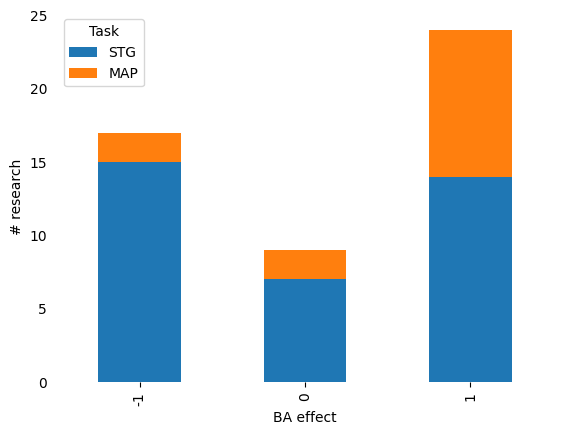

In [2]:
# stack plot across MAP and STG regardless of within/between design or sample size

research_num = chapter1MA.groupby('BA_effect')['Task'].value_counts(normalize=False)
wide_research_num = research_num.unstack()
wide_research_num = wide_research_num[['STG', 'MAP']] 
wide_research_num.plot(kind="bar", stacked=True)

# Remove background and spines
plt.gca().set_facecolor('none')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show ticks on x-axis and y-axis
plt.tick_params(left=False, bottom=True)
plt.grid(False)
plt.xlabel("BA effect")
plt.ylabel("# research")
plt.legend(title="Task")
plt.show()


The results shown above show that the Betrayal Aversion (BA) effect was mostly driven by a specific task procedure (MAP).

In [3]:
# figure setting
# Reset rcParams to default values
mpl.rcParams.update()
# globally setting seaborn
sns.set(style='ticks', palette='muted', font_scale=1.2, context='notebook')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['font.size'] = 16

Remove some unnecessary cols, and save them as the new sliced dataset. 

In [4]:
sl_all_avg = all_avg_120.iloc[:,4:].reset_index(drop=True)
sl_both75_avg = both75_avg_102.iloc[:,4:].reset_index(drop=True)
sl_both75_unfold = both75_unfold_102.iloc[:,2:].reset_index(drop=True)
sl_dg75_avg = dg75_avg_113.iloc[:,4:].reset_index(drop=True)
sl_dg75_unfold= dg75_unfold_113.iloc[:,2:].reset_index(drop=True)
sl_tg75_avg = tg75_avg_106.iloc[:,4:].reset_index(drop=True)
sl_tg75_unfold = tg75_unfold_106.iloc[:,2:].reset_index(drop=True)


* Merging the current dataset with another dataset with the (BLUPs) Best Linear Unbiased Prediction score obtained from micro-macro mixed models 
* Rename columns in new dataframe 
* Calculate trustworthiness by averaging decisions across five trust contexts

In [5]:
# merging current dataset with another dataset with Best linear unbiased prediction score obtained from R 
#match columns to match from both df left_keys are in sl_..75_avg, right_keys are in blup
left_keys = ['Age', 'Betrayal', 'Anger', 'Sadness', 'Disgust', 'Surprise', 'Cog_Motivate', 'Cog_Reasons', 'Cog_Defend', 'Cog_ToM','IRIpt', 'IRIfs','IRIec', 'IRIpd']
right_keys = ['age','betrayal', 'anger', 'sadness', 'disgust', 'surprise', 'motivation',    'reason',     'defend',  'perspective','IRI_pt', 'IRI_fs', 'IRI_ec', 'IRI_pd']
#import each df
blup_df_both = pd.read_csv(dirname + 'BLUP_predictors_both75_raw.csv')
blup_df_dg = pd.read_csv(dirname + 'BLUP_predictors_dg75_raw.csv')
blup_df_tg = pd.read_csv(dirname +'BLUP_predictors_tg75_raw.csv')

#selected columns
blup_cols = [col for col in blup_df_both.columns if not col.endswith('.x') and ('c.' in col or 
              col in ['female.y', 'british.y'])]
sl_cols = list(sl_both75_avg.columns)
sl_cols.extend(blup_cols)

#merge two df based on given keys, return error if one row match multiple rows
sl_both75_avg = sl_both75_avg.merge(
    blup_df_both,
    left_on=left_keys,
    right_on = right_keys,
    validate="one_to_one"
    )
#extract wanted columns
sl_both75_avg=sl_both75_avg[sl_cols]
#rename cols
sl_both75_avg.columns = sl_both75_avg.columns.str.replace('.', '_', regex=True).str.replace('_y','')

# repeat for dg
sl_dg75_avg=sl_dg75_avg.merge(
    blup_df_dg,
    left_on=left_keys,
    right_on = right_keys,
    validate="one_to_one"
    )
sl_dg75_avg=sl_dg75_avg[sl_cols]
sl_dg75_avg.columns = sl_dg75_avg.columns.str.replace('.', '_', regex=True).str.replace('_y','')
#repeat for tg
sl_tg75_avg=sl_tg75_avg.merge(
    blup_df_tg,
    left_on=left_keys,
    right_on = right_keys,
    validate="one_to_one"
    )
sl_tg75_avg=sl_tg75_avg[sl_cols]
sl_tg75_avg.columns = sl_tg75_avg.columns.str.replace('.', '_', regex=True).str.replace('_y','')


# turstworhiness 

dataframes = [sl_all_avg, sl_both75_avg, sl_both75_unfold, sl_dg75_avg, sl_dg75_unfold, sl_tg75_avg, sl_tg75_unfold]
names = ['sl_all_avg', 'sl_both75_avg', 'sl_both75_unfold', 'sl_dg75_avg', 'sl_dg75_unfold', 'sl_tg75_avg', 'sl_tg75_unfold']
tg_multi=3
for df, name in zip(dataframes, names):
    df['trustworthiness_avg'] = (df['trstee_ST1']/(tg_multi*2) +\
         df['trstee_ST2']/(tg_multi*4) + \
            df['trstee_ST3']/(tg_multi*6) + \
                df['trstee_ST4']/(tg_multi*8) + \
                    df['trstee_ST5']/(tg_multi*10)) / 5
    filename = f"{name}.csv"  
    df.to_csv(filename, index=False) # Save the dataframe as a CSV file using the file name


In [6]:
sl_tg75_avg_blups = pd.read_csv("sl_tg75_avg.csv")
sl_dg75_avg_blups = pd.read_csv("sl_dg75_avg.csv")
sl_both75_avg_blups = pd.read_csv("sl_both75_avg.csv")



* Mean center the variables
* log transform the response time

In [7]:
## mean center
# tg75
sl_tg75_avg_blups['trustworthiness_c'] = sl_tg75_avg_blups['trustworthiness_avg'] - sl_tg75_avg_blups['trustworthiness_avg'].mean()
sl_tg75_avg_blups['BIS11ATT_c'] = sl_tg75_avg_blups['BIS11ATT'] - sl_tg75_avg_blups['BIS11ATT'].mean()
sl_tg75_avg_blups['BIS11MT_c'] = sl_tg75_avg_blups['BIS11MT'] - sl_tg75_avg_blups['BIS11MT'].mean()
sl_tg75_avg_blups['BIS11NP_c'] = sl_tg75_avg_blups['BIS11NP'] - sl_tg75_avg_blups['BIS11NP'].mean()
sl_tg75_avg_blups['trustAttitude_c'] = sl_tg75_avg_blups['trustAttitude'] - sl_tg75_avg_blups['trustAttitude'].mean()
sl_tg75_avg_blups['riskTaking_c'] = sl_tg75_avg_blups['riskTaking'] - sl_tg75_avg_blups['riskTaking'].mean()
sl_tg75_avg_blups['TG_exptRatio_c'] = sl_tg75_avg_blups['TG_exptRatio'] - sl_tg75_avg_blups['TG_exptRatio'].mean()
sl_tg75_avg_blups['TG_exptRatioAdj_c'] = sl_tg75_avg_blups['TG_exptRatioAdj'] - sl_tg75_avg_blups['TG_exptRatioAdj'].mean()
# dg75
sl_dg75_avg_blups['trustworthiness_c'] = sl_dg75_avg_blups['trustworthiness_avg'] - sl_dg75_avg_blups['trustworthiness_avg'].mean()
sl_dg75_avg_blups['BIS11ATT_c'] = sl_dg75_avg_blups['BIS11ATT'] - sl_dg75_avg_blups['BIS11ATT'].mean()
sl_dg75_avg_blups['BIS11MT_c'] = sl_dg75_avg_blups['BIS11MT'] - sl_dg75_avg_blups['BIS11MT'].mean()
sl_dg75_avg_blups['BIS11NP_c'] = sl_dg75_avg_blups['BIS11NP'] - sl_dg75_avg_blups['BIS11NP'].mean()
sl_dg75_avg_blups['trustAttitude_c'] = sl_dg75_avg_blups['trustAttitude'] - sl_dg75_avg_blups['trustAttitude'].mean()
sl_dg75_avg_blups['riskTaking_c'] = sl_dg75_avg_blups['riskTaking'] - sl_dg75_avg_blups['riskTaking'].mean()
sl_dg75_avg_blups['TG_exptRatio_c'] = sl_dg75_avg_blups['TG_exptRatio'] - sl_dg75_avg_blups['TG_exptRatio'].mean()
sl_dg75_avg_blups['TG_exptRatioAdj_c'] = sl_dg75_avg_blups['TG_exptRatioAdj'] - sl_dg75_avg_blups['TG_exptRatioAdj'].mean()

# RT log transformation
sl_tg75_avg_blups["log_TG_trustorRT"]= np.log(sl_tg75_avg_blups["TG_trustorRT"])
sl_tg75_avg_blups["log_DG_dictatorRT"]= np.log(sl_tg75_avg_blups["DG_dictatorRT"])
sl_tg75_avg_blups["log_TG_expectRT"] = np.log(sl_tg75_avg_blups["TG_expectRT"])
sl_tg75_avg_blups["log_TG_closeRT"] = np.log(sl_tg75_avg_blups["TG_closeRT"])
sl_tg75_avg_blups["log_DG_closeRT"] = np.log(sl_tg75_avg_blups["DG_closeRT"])

Examine how IV (emotions, dispositions, and social cognitions) can predict trust and altruistic behaviour.  

Regression examinations between incentivized decisions and the emotion BLUPs score 

In [8]:
## trust as DV
tg_vs_emotions = ols('TG_trustor ~ female + c_income + c_age + c_education	+ british  + BLUP_c_betrayal + BLUP_c_anger + BLUP_c_sadness + BLUP_c_surprise \
                     + BLUP_c_disgust + BLUP_c_person + c_tg_close', data = sl_tg75_avg_blups).fit()
dg_vs_emotions = ols('DG_dictator ~ female + c_income + c_age + c_education	+ british  + BLUP_c_betrayal + BLUP_c_anger + BLUP_c_sadness + BLUP_c_surprise \
                     + BLUP_c_disgust + BLUP_c_person + c_dg_close', data = sl_tg75_avg_blups).fit()
tg_vs_rt = ols('TG_trustor ~ female + c_income + c_age + c_education + british  + log_TG_trustorRT + log_TG_expectRT+log_TG_closeRT', data =  sl_tg75_avg_blups ).fit()
tg_vs_impulsiveness = ols('TG_trustor ~ female + c_income + c_age + c_education	+ british + BIS11ATT_c + BIS11MT_c + BIS11NP_c', data =  sl_tg75_avg_blups ).fit()
tg_vs_IRI = ols('TG_trustor ~ female + c_income + c_age + c_education + british + c_IRI_pt + c_IRI_fs + c_IRI_ec + c_IRI_pd',  data =  sl_tg75_avg_blups ).fit()
             

models = [tg_vs_emotions, dg_vs_emotions, tg_vs_rt, tg_vs_impulsiveness, tg_vs_IRI]
# loop through each model and print its VIF values
for model in models:
    # Get the design matrix (excluding the intercept) from the fitted model
    X = model.model.exog[:, 1:]
    # Calculate the VIF values for each predictor variable
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    vif["Predictor"] = model.model.exog_names[1:]
    # Print the VIF values for each predictor variable
    print("Model Summary:", model.summary())
    print("VIF:")
    print(vif)
    print()           
                

Model Summary:                             OLS Regression Results                            
Dep. Variable:             TG_trustor   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     5.415
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           6.79e-07
Time:                        03:02:40   Log-Likelihood:                -231.99
No. Observations:                 106   AIC:                             490.0
Df Residuals:                      93   BIC:                             524.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.2340 

**Summary**
* It turns out that higher Betrayal sensitivity is a positive predictor for more trust behvaiour (instead of the opposite).
* While Anger serves as a negative predictor for both trust and altruistic behaviour, sadness is specifically positively associated with more altruistic behaviour. 
* Respons time during trust decisions and during the expectation period is also associated with more trust behaviour. (However, models with RT as an explanatory variable suffer from multicollinearity inflation problems)
* Attentional impulsiveness is associated with more trust. 

Illustration of association between betrayal / anger and trust behvaiour

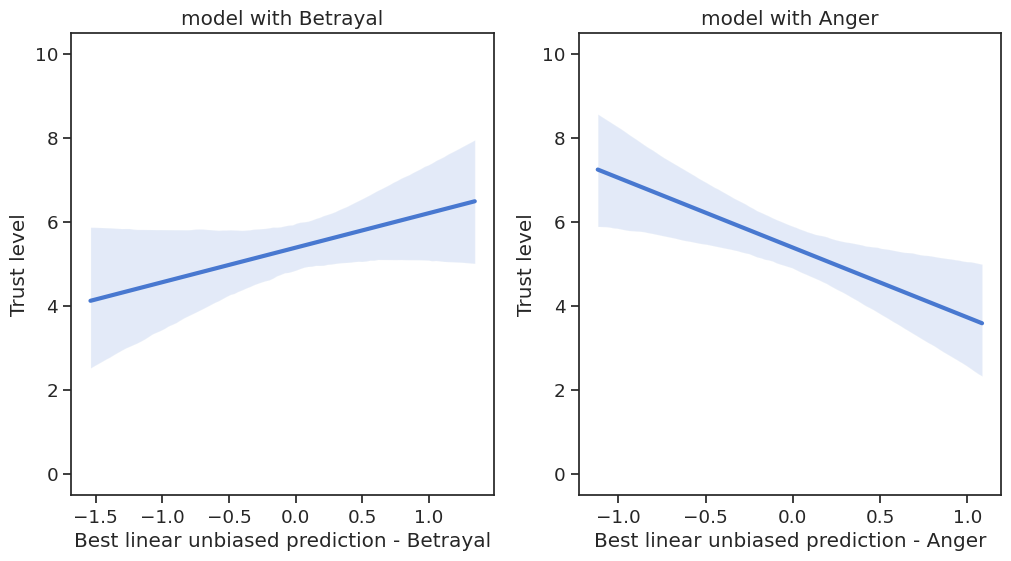

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.regplot(data=sl_tg75_avg_blups, x='BLUP_c_betrayal', y='TG_trustor', ax=ax1, scatter_kws={'s': 0})
ax1.set_xlabel('Best linear unbiased prediction - Betrayal')
ax1.set_ylabel('Trust level')
ax1.set_title('model with Betrayal')

sns.regplot(data=sl_tg75_avg_blups, x='BLUP_c_anger', y='TG_trustor', ax=ax2, scatter_kws={'s': 0})
ax2.set_xlabel('Best linear unbiased prediction - Anger')
ax2.set_ylabel('Trust level')
ax2.set_title('model with Anger')

plt.show()


* Illustration of the associaiton between trust behvaiour and different impulsiveness measuremnt
* Only attention scale (BIS11 ATT) is significant 

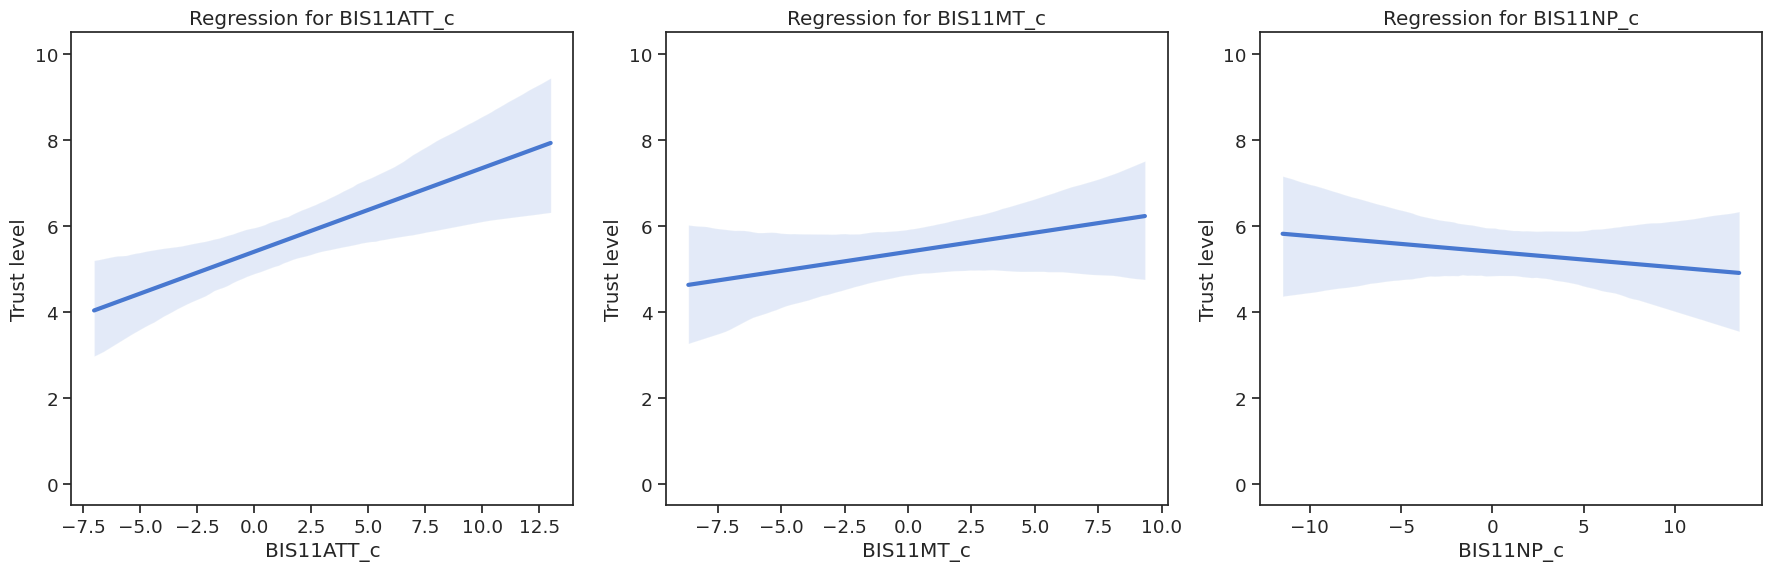

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the regression line for 'BIS11ATT_c'
sns.regplot(data=sl_tg75_avg_blups, x='BIS11ATT_c', y='TG_trustor', ax=axs[0], scatter_kws={'s': 0})
axs[0].set_xlabel('BIS11ATT_c')
axs[0].set_ylabel('Trust level')
axs[0].set_title('Regression for BIS11ATT_c')

# Plot the regression line for 'BIS11MT_c'
sns.regplot(data=sl_tg75_avg_blups, x='BIS11MT_c', y='TG_trustor', ax=axs[1], scatter_kws={'s': 0})
axs[1].set_xlabel('BIS11MT_c')
axs[1].set_ylabel('Trust level')
axs[1].set_title('Regression for BIS11MT_c')

# Plot the regression line for 'BIS11NP_c'
sns.regplot(data=sl_tg75_avg_blups, x='BIS11NP_c', y='TG_trustor', ax=axs[2], scatter_kws={'s': 0})
axs[2].set_xlabel('BIS11NP_c')
axs[2].set_ylabel('Trust level')
axs[2].set_title('Regression for BIS11NP_c')


plt.tight_layout()
plt.show()


illustration of social cognition ( Interpersonal Reactivity Index ) and trust behaviour 

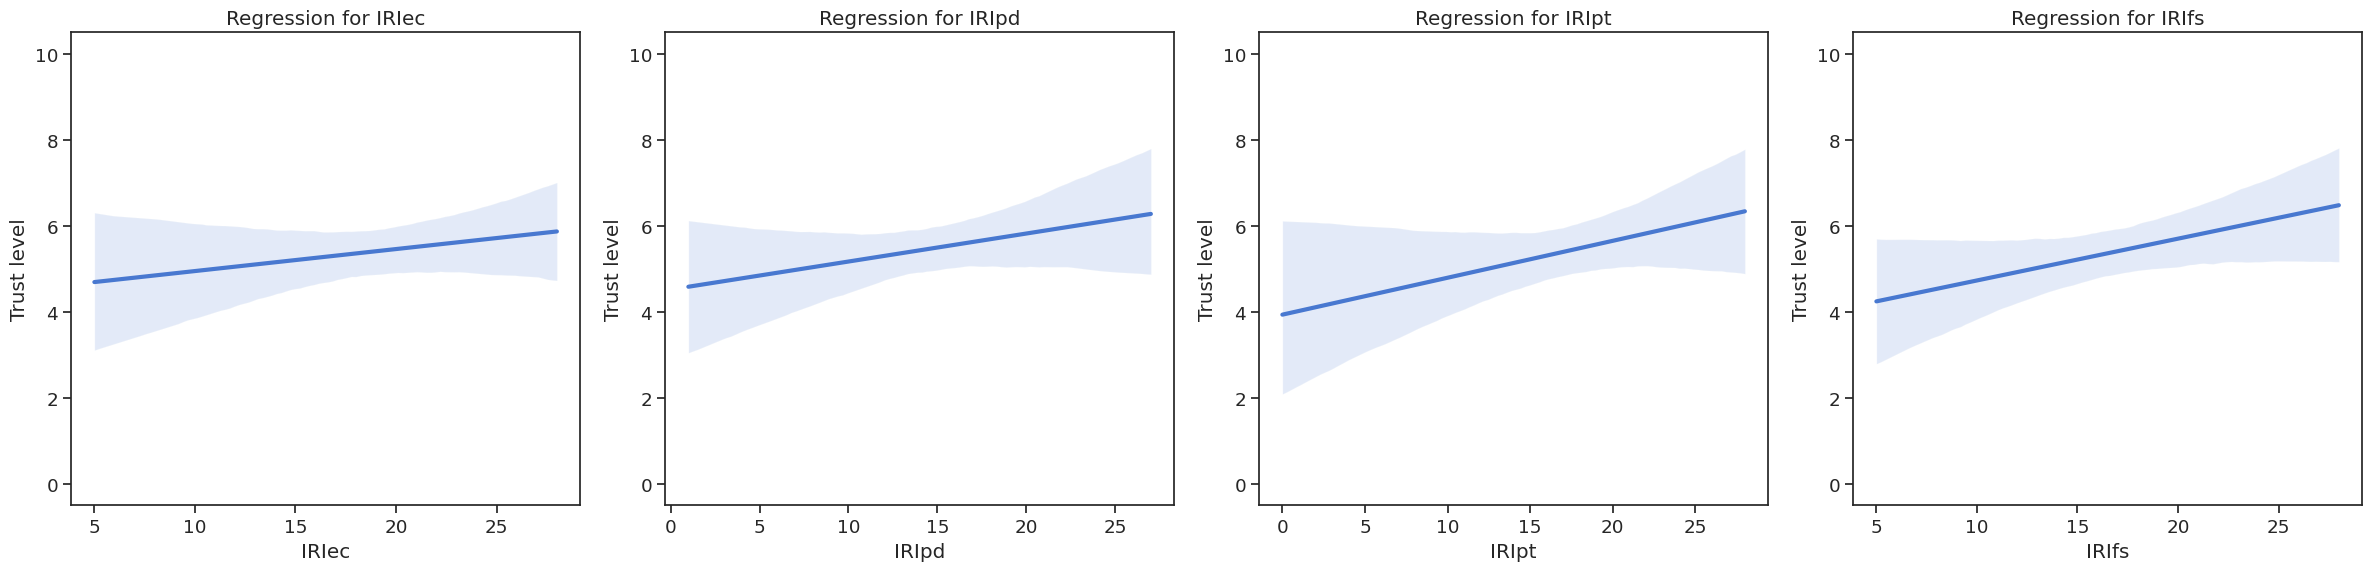

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with four subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# List of IRI variables
iri_variables = ['IRIec', 'IRIpd', 'IRIpt', 'IRIfs']

# Iterate over IRI variables to plot the regression lines
for i, variable in enumerate(iri_variables):
    # Plot the regression line for the current variable
    sns.regplot(data=sl_tg75_avg_blups, x=variable, y='TG_trustor', ax=axs[i], scatter_kws={'s': 0})
    
    # Set labels and title for each subplot
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Trust level')
    axs[i].set_title(f'Regression for {variable}')


plt.tight_layout()
plt.show()


* Illustration of RT and trust behaviour
* Response time during trust decisions (trsutor log RT) and during considering the expectation of the return (expect RT) significantly predict higher trust levels. 

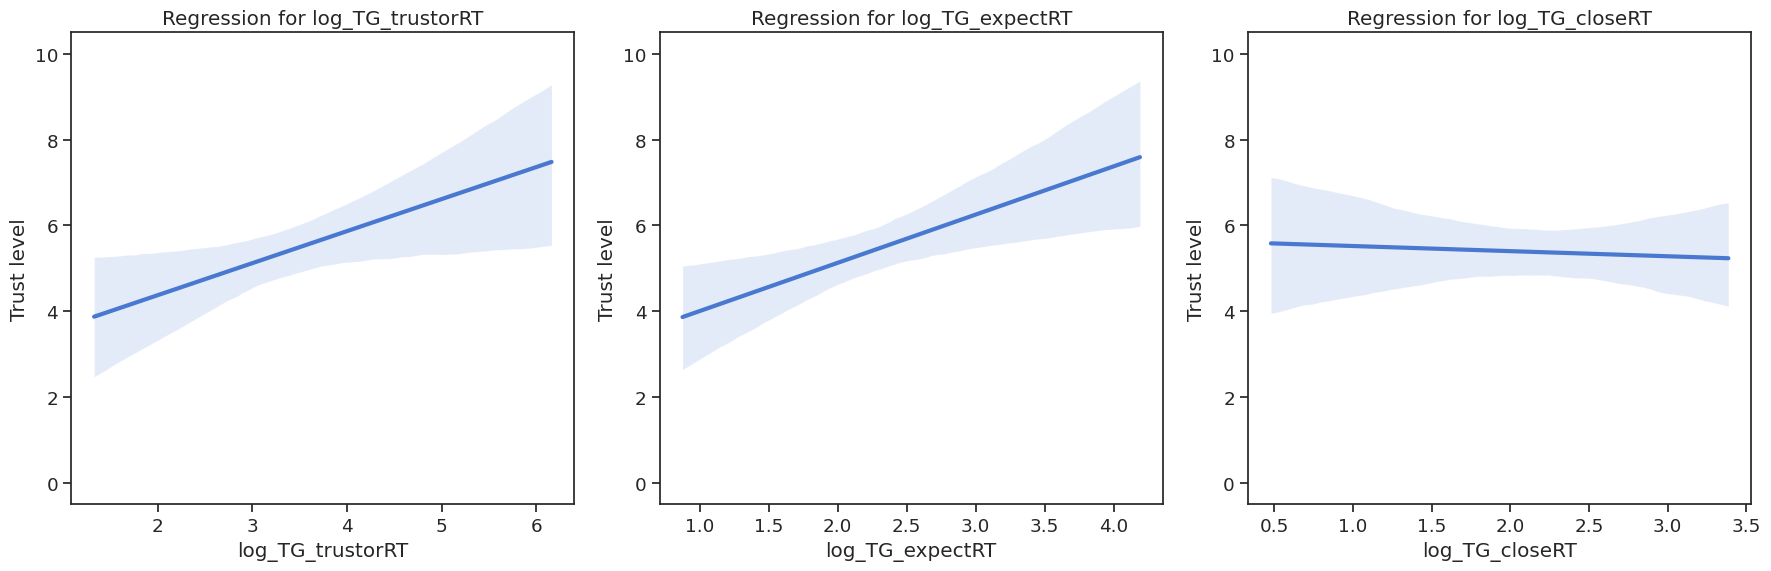

In [12]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
independent_vars = ['log_TG_trustorRT', 'log_TG_expectRT', 'log_TG_closeRT']

# Iterate over independent variables to plot the regression lines
for ax, iv in zip(axs, independent_vars):
    # Plot the regression line
    sns.regplot(data=sl_tg75_avg_blups, x=iv, y='TG_trustor', ax=ax, scatter_kws={'s': 0})
    
    # Set labels and title for each subplot
    ax.set_xlabel(iv)
    ax.set_ylabel('Trust level')
    ax.set_title(f'Regression for {iv}')


plt.tight_layout()
plt.show()


**Finally, let's take a look at a correlation heatmap with all variables for some hints for the next step. **

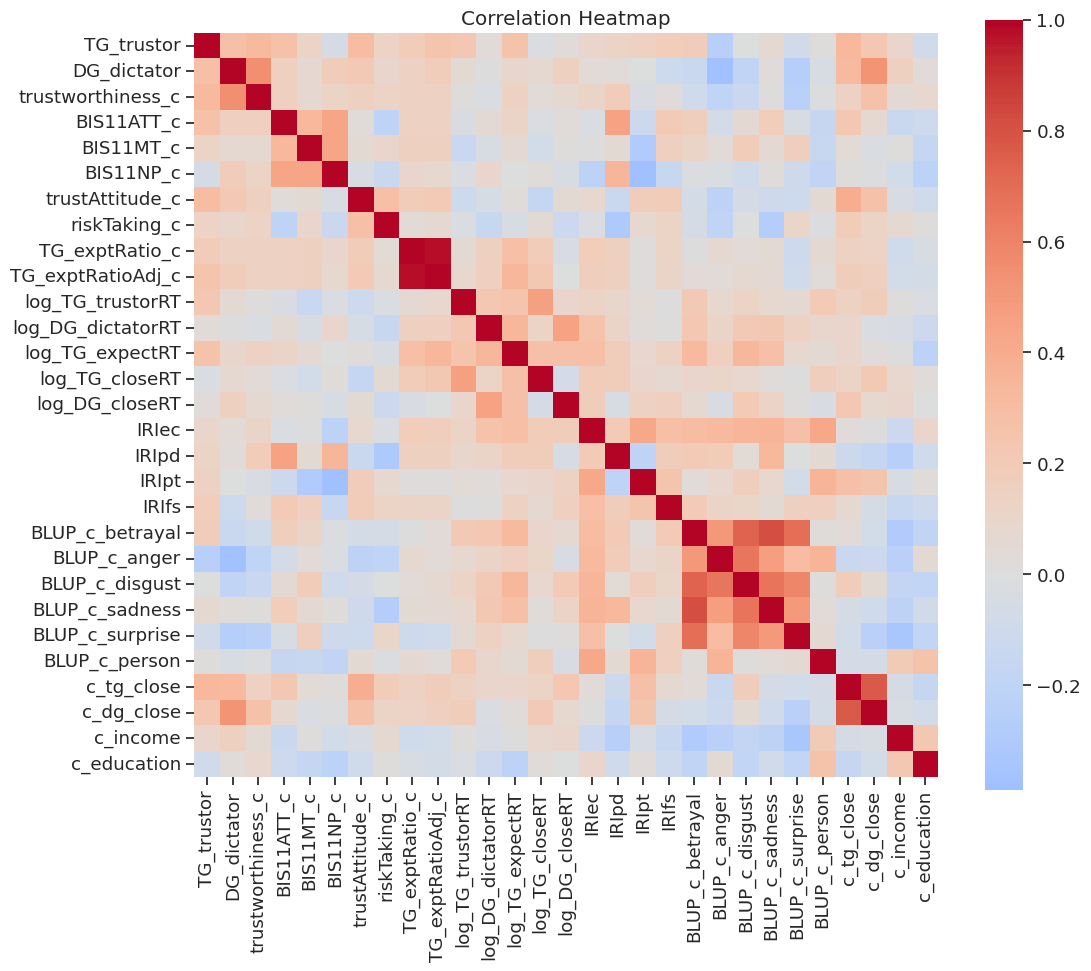

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the variables for the correlation heatmap
variables = ['TG_trustor', 'DG_dictator','trustworthiness_c', 'BIS11ATT_c', 'BIS11MT_c', 'BIS11NP_c', 'trustAttitude_c', 'riskTaking_c',
             'TG_exptRatio_c', 'TG_exptRatioAdj_c', 'log_TG_trustorRT', 'log_DG_dictatorRT', 'log_TG_expectRT',
             'log_TG_closeRT', 'log_DG_closeRT', 'IRIec', 'IRIpd', 'IRIpt', 'IRIfs', 'BLUP_c_betrayal',
             'BLUP_c_anger', 'BLUP_c_disgust', 'BLUP_c_sadness', 'BLUP_c_surprise', 'BLUP_c_person',
             'c_tg_close', 'c_dg_close', 'c_income', 'c_education']

# Create a correlation matrix for the selected variables
correlation_matrix = sl_tg75_avg_blups[variables].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt="", center = 0, square=True)

plt.title('Correlation Heatmap')
plt.show()


Use lasso regression to select important predictors, shrink unimportnat variables's coefficient to zero. Below is visualization of lasso results of emotion model on trust behaviour. 

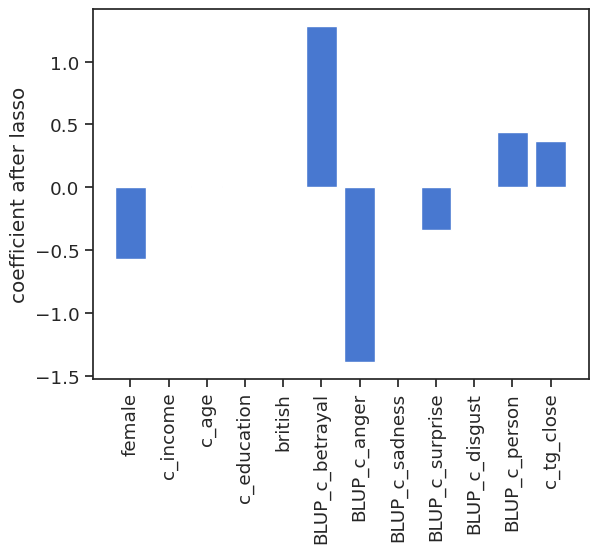

In [14]:
## LASSO

selected_cols = ['female', 'c_income', 'c_age', 'c_education', "british", "BLUP_c_betrayal", "BLUP_c_anger", "BLUP_c_sadness", "BLUP_c_surprise",\
                    "BLUP_c_disgust", "BLUP_c_person", "c_tg_close"]
X = sl_tg75_avg_blups[selected_cols].values
y = sl_tg75_avg_blups["TG_trustor"].values

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_

plt.bar(selected_cols, lasso_coef)
plt.xticks(rotation=90)
plt.ylabel('coefficient after lasso')
plt.show()

# LASSO cross validation: 10-fold

                 Lasso Coefficient
female                   -0.484342
c_income                  0.000000
c_age                     0.003850
c_education              -0.007927
british                   0.179770
BLUP_c_betrayal           2.689240
BLUP_c_anger             -2.559934
BLUP_c_sadness           -0.034724
BLUP_c_surprise          -1.369340
BLUP_c_disgust            0.000000
BLUP_c_person             1.675812
c_tg_close                0.336468


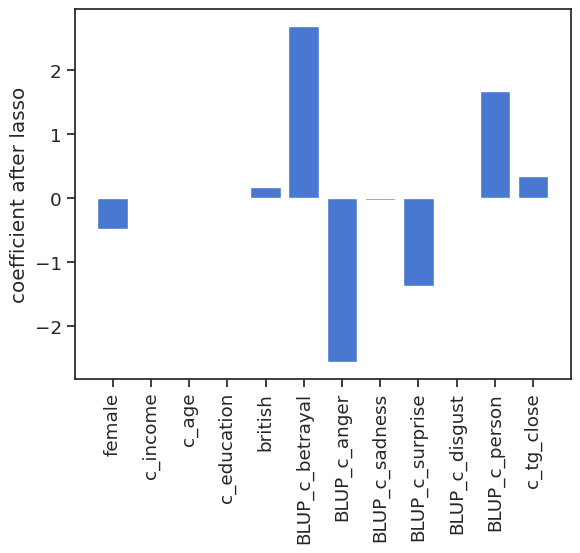

In [15]:
## LASSO cross validation (LASSO CV)

selected_cols = ['female', 'c_income', 'c_age', 'c_education', "british", "BLUP_c_betrayal", "BLUP_c_anger", "BLUP_c_sadness", "BLUP_c_surprise",\
                    "BLUP_c_disgust", "BLUP_c_person", "c_tg_close"]

X = sl_tg75_avg_blups[selected_cols].values
y = sl_tg75_avg_blups["TG_trustor"].values

cv = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_cv = LassoCV(cv=cv, random_state=0)
lasso_cv.fit(X, y)
lasso_coef = lasso_cv.coef_

coef_df = pd.DataFrame(lasso_coef, index=selected_cols, columns=["Lasso Coefficient"])
print(coef_df)

plt.bar(selected_cols, lasso_coef)
plt.xticks(rotation=90)
plt.ylabel('coefficient after lasso')
plt.show()